In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from cdrift import evaluation
from cdrift.utils.helpers import readCSV_Lists, convertToTimedelta
import numpy as np
from datetime import datetime
from statistics import mean, harmonic_mean, stdev

LAG_WINDOW = 200

### Read the CSV and split by approach

In [2]:
df = readCSV_Lists("evaluation_results.csv")

def split_by_name(df):
    return [
        (alg, df[df["Algorithm"] == alg])
        for alg in df["Algorithm"].unique()
    ]

dfs = split_by_name(df)
df.Algorithm.unique()

for name, d in split_by_name(pd.read_csv("evaluation_results.csv")):
    print(f"{name} contains duplicate rows: {d.duplicated().any()}")

Process Graph Metrics contains duplicate rows: True
Martjushev ADWIN J contains duplicate rows: True
Martjushev ADWIN WC contains duplicate rows: True
Zheng DBSCAN contains duplicate rows: False
Maaradji Runs contains duplicate rows: False
Bose J contains duplicate rows: False
Bose WC contains duplicate rows: False
Earth Mover's Distance contains duplicate rows: False


In [3]:
df_csv = pd.read_csv("evaluation_results.csv")
df_m = df_csv[df_csv["Algorithm"] == "Martjushev ADWIN J"]
df_m[df_m.duplicated(keep=False)].sort_values(by=["Log", "Min Adaptive Window", "Max Adaptive Window", "Duration", "Detected Changepoints"])

,Algorithm,Log Source,Log,Min Adaptive Window,Max Adaptive Window,Detected Changepoints,Actual Changepoints for Log,F1-Score,Average Lag,Duration,P-Value,MRID,Epsilon,Window Size,SW Step Size
15667,Martjushev ADWIN J,Ostovar,Atomic_ConditionalRemoval_output_ConditionalRe...,400.0,400.0,[],"[999, 1999]",NaN,NaN,00:06:51,0.4,NaN,NaN,NaN,NaN
18401,Martjushev ADWIN J,Ostovar,Atomic_ConditionalRemoval_output_ConditionalRe...,400.0,400.0,[],"[999, 1999]",NaN,NaN,00:06:51,0.4,NaN,NaN,NaN,NaN
1313,Martjushev ADWIN J,Ostovar,Atomic_Frequency_output_Frequency,300.0,500.0,[499],"[999, 1999]",NaN,NaN,00:02:28,0.4,NaN,NaN,NaN,NaN
24888,Martjushev ADWIN J,Ostovar,Atomic_Frequency_output_Frequency,300.0,500.0,[499],"[999, 1999]",NaN,NaN,00:02:28,0.4,NaN,NaN,NaN,NaN
5844,Martjushev ADWIN J,Ostovar,Atomic_Frequency_output_Frequency_2,100.0,400.0,[],"[999, 1999]",NaN,NaN,00:03:46,0.4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26497,Martjushev ADWIN J,Ceravolo,sudden_trace_noise5_1000_sw,300.0,700.0,[],[499],NaN,NaN,00:00:09,0.4,NaN,NaN,NaN,NaN
14630,Martjushev ADWIN J,Ceravolo,sudden_trace_noise5_1000_sw,400.0,400.0,[],[499],NaN,NaN,00:00:07,0.4,NaN,NaN,NaN,NaN
26028,Martjushev ADWIN J,Ceravolo,sudden_trace_noise5_1000_sw,400.0,400.0,[],[499],NaN,NaN,00:00:07,0.4,NaN,NaN,NaN,NaN
1324,Martjushev ADWIN J,Ceravolo,sudden_trace_noise5_1000_sw,400.0,700.0,[],[499],NaN,NaN,00:00:06,0.4,NaN,NaN,NaN,NaN


### Split into noisy/noiseful logs

In [4]:
logs = zip(df["Log Source"], df["Log"])

noiseless_logs = {
    log for source, log in logs if 
    (source == "Ostovar"  and not (log.endswith("_2") or log.endswith("_5"))) or
    (source == "Ceravolo" and log.split("_")[2]=="noise0") or
    source == "Bose"
}

df_noiseless = df[df["Log"].isin(noiseless_logs)]
df_noisy = df[df["Log"].isin(noiseless_logs) == False]

dfs_noisy = split_by_name(df_noisy)
dfs_noiseless = split_by_name(df_noiseless)

## Accuracy
- All Change-Patterns
- Only 0 Noise
- Max cummulative *Recall* achieved of all parameter settings

In [5]:
df["Algorithm"].unique()

array(['Process Graph Metrics', 'Martjushev ADWIN J',
       'Martjushev ADWIN WC', 'Zheng DBSCAN', 'Maaradji Runs', 'Bose J',
       'Bose WC', "Earth Mover's Distance"], dtype=object)

In [6]:
bose_j_df = df_noiseless[df_noiseless["Algorithm"] == "Bose J"]
bose_wc_df = df_noiseless[df_noiseless["Algorithm"] == "Bose WC"]

bose_j_accuracies = dict() # Mapping tuple of parameter values to achieved accuracy

used_parameters = {
        "Bose J": ["Window Size", "SW Step Size"],
        "Bose WC": ["Window Size", "SW Step Size"],
        "Martjushev ADWIN J": ["Min Adaptive Window", "Max Adaptive Window", "P-Value"],
        "Martjushev ADWIN WC": ["Min Adaptive Window", "Max Adaptive Window", "P-Value"],
        "Maaradji Runs": ["Window Size"],#, "SW Step Size"],
        "Earth Mover's Distance": ["Window Size", "SW Step Size"],
        # Forgot to write down PValue for Process Graph Metrics
        "Process Graph Metrics": ["Min Adaptive Window", "Max Adaptive Window", "P-Value"],
        "Zheng DBSCAN": ["MRID", "Epsilon"]
    }



def calcAccuracy(df, param_names, lag_window):
    accuracies = dict()
    for parameters, group in df.groupby(by=param_names):
        # Calculate Accuracy for this parameter setting
        ## --> F1-Score, but first collect all TP and FP
        tps = 0
        fps = 0
        positives = 0
        detected = 0

        for index, row in group.iterrows():
            actual_cp = row["Actual Changepoints for Log"]
            detected_cp = row["Detected Changepoints"]
            tp, fp = evaluation.getTP_FP(detected_cp, actual_cp, lag_window)
            tps += tp
            fps += fp
            positives += len(actual_cp)
            detected += len(detected_cp)
        if positives != 0 and detected != 0:
            precision = tps / detected
            recall = tps / positives
            accuracies[parameters] = recall
        else:
            accuracies[parameters] = np.NaN
    return accuracies

computed_accuracy_dicts = dict()
accuracies = dict()
for name, a_df in dfs_noiseless:
    if name != "Process Graph Metrics":
        result = calcAccuracy(a_df, used_parameters[name], LAG_WINDOW)
        computed_accuracy_dicts[name] = result
        accuracies[name] = max(result.values())
        print(f"{name}: {accuracies[name]}")

Martjushev ADWIN J: 0.7536231884057971
Martjushev ADWIN WC: nan
Zheng DBSCAN: 0.9420289855072463
Earth Mover's Distance: 0.9420289855072463
Bose J: 0.8840579710144928
Bose WC: 0.7681159420289855
Maaradji Runs: 0.42028985507246375


## Latency
- Using best parameter setting
- Same logs as above

In [7]:
from statistics import mean
def calcLatency(df, param_names, lag_window):
    latencies = dict()
    for parameters, group in df.groupby(by=param_names):
        # Calculate Accuracy for this parameter setting
        lags = []
        for index, row in group.iterrows():
            actual_cp = row["Actual Changepoints for Log"]
            detected_cp = row["Detected Changepoints"]
            assignments = evaluation.assign_changepoints(detected_cp, actual_cp)
            for d,a in assignments:
                lags.append(abs(d-a))
        if len(lags) != 0:
            # Scale Latency from 0 to 1
            avg_lag = 1-(mean(lags)/lag_window)
        else:
            avg_lag = np.NaN
        latencies[parameters] = avg_lag
    return latencies

computed_latency_dicts = dict()
latencies = dict()
for name, a_df in dfs_noiseless:
    if name != "Process Graph Metrics":
        result = calcLatency(a_df, used_parameters[name], LAG_WINDOW)
        computed_latency_dicts[name] = result
        latencies[name] = min(result.values())
        print(f"{name}: {(1-latencies[name])*200} Traces; Score: {latencies[name]}")

Martjushev ADWIN J: 80.13669064748201 Traces; Score: 0.5993165467625899
Martjushev ADWIN WC: nan Traces; Score: nan
Zheng DBSCAN: 70.32887753478892 Traces; Score: 0.6483556123260554
Earth Mover's Distance: 57.76923076923075 Traces; Score: 0.7111538461538462
Bose J: 66.20833333333334 Traces; Score: 0.6689583333333333
Bose WC: 87.05882352941177 Traces; Score: 0.5647058823529412
Maaradji Runs: 62.904761904761905 Traces; Score: 0.6854761904761905


## Versatility

In [8]:
versatilities = {name: np.NaN for name in df["Algorithm"].unique()}

mapping_ostovar_cp_ceravolo = {
    ("ConditionalMove", "cm"),
    ("ConditionalRemoval", ),
    ("ConditionalToSequence", "cf"),
    ("Frequency", "fr"),
    ("Loop", "lp"),
    ("ParallelMove", "pm"),
    ("ParallelRemoval", ),
    ("ParallelToSequence", "pl"),
    ("SerialMove", ),
    ("SerialRemoval", ),
    ("Skip", "cb"),
    ("Substitute", "rp"),
    ("Swap", "sw"),
}
# mapping_ostovar_cp_ceravolo = {
#     {"ConditionalMove", },
#     {"ConditionalRemoval", },
#     {"ConditionalToSequence", "cf"},
#     {"Frequency", },
#     {"Loop", "lp"},
#     {"ParallelMove", "pm"},
#     {"ParallelRemoval", },
#     {"ParallelToSequence", "pl"},
#     {"SerialMove", },
#     {"SerialRemoval", },
#     {"Skip", "cb"},
#     {"Substitute", "rp"},
#     {"Swap", "sw"},
# }

In [9]:
ceravolo_patterns = list({       
        logname.split("_")[-1]
        for logname in df_noiseless[df_noiseless["Log Source"] == "Ceravolo"]["Log"].unique()
})

ceravolo_patterns.sort(key=lambda x:len(x))
ceravolo_patterns

['pm',
 'pl',
 'cp',
 'sw',
 'cf',
 'cb',
 'rp',
 'cd',
 'lp',
 're',
 'IOR',
 'OIR',
 'RIO',
 'IRO',
 'ROI']

In [10]:
ostovar_patterns = list({       
        logname.split('_')[-1]
        for logname in df_noiseless[df_noiseless["Log Source"] == "Ostovar"]["Log"].unique()
})

ostovar_patterns.sort(key=lambda x:len(x))
ostovar_patterns

['OIR',
 'RIO',
 'ROI',
 'ORI',
 'IOR',
 'IRO',
 'Loop',
 'Skip',
 'Swap',
 'Frequency',
 'Substitute',
 'SerialMove',
 'ParallelMove',
 'SerialRemoval',
 'ParallelRemoval',
 'ConditionalMove',
 'ParallelToSequence',
 'ConditionalRemoval',
 'ConditionalToSequence']

## Scalability
- Mean Duration
- Across ***all*** logs this time!

In [11]:
scalabilities = dict()
for name, a_df in dfs:
    result = a_df["Duration"].mean()
    result_str = datetime.strftime(datetime.utcfromtimestamp(result.seconds), '%H:%M:%S')
    scalabilities[name] = result
    print(f"{name}: {result_str}")

Process Graph Metrics: 00:00:25
Martjushev ADWIN J: 00:04:06
Martjushev ADWIN WC: 00:02:29
Zheng DBSCAN: 00:00:03
Maaradji Runs: 00:04:45
Bose J: 00:11:32
Bose WC: 00:11:24
Earth Mover's Distance: 00:16:54


## Parameter Sensitivity
- For each Parameter setting, harmonic mean of *accuracy*, *latency*, and *versatility*
  - &rarr; Visualize the variance, etc., with a boxplot

In [12]:
import seaborn as sns
sensitivities = dict()
for name in df["Algorithm"].unique():
    _sensitivities = dict()
    if name != "Process Graph Metrics":
        acc = computed_accuracy_dicts[name]
        lat = computed_latency_dicts[name]
        for param_choice in acc.keys():
            sensitivity = harmonic_mean([acc[param_choice], lat[param_choice]])
            _sensitivities[param_choice] = sensitivity
        sensitivities[name] = _sensitivities


<AxesSubplot:xlabel='Observed Performances', ylabel='Algorithm'>

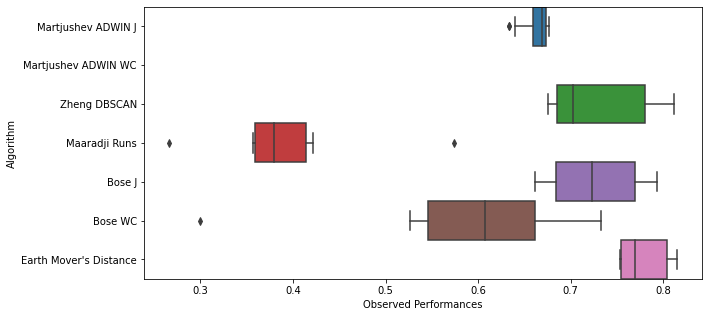

In [13]:
sens_df = pd.DataFrame([
    {
        "Parameters": param,
        "Algorithm": name,
        "Observed Performances": sens
    }
    for name, sens_dict in sensitivities.items()
    for param, sens in sens_dict.items()
])
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=sens_df, x="Observed Performances", y="Algorithm", width=1, ax=ax)

In [14]:
# Standard Deviation
print("Standard Deviations")
sensitivity_stds = dict()
for name, sens in sensitivities.items():
    try:
        std = stdev(sens.values())
    except:
        std = np.NaN
    sensitivity_stds[name] = std
    print(f"{name}: {std}")

Standard Deviations
Martjushev ADWIN J: 0.015688172247205142
Martjushev ADWIN WC: nan
Zheng DBSCAN: 0.047956190307036746
Maaradji Runs: 0.10146858184237247
Bose J: 0.055111064851049156
Bose WC: 0.1520628486397899
Earth Mover's Distance: 0.02880039527329389


### Robustness

In [15]:
robustnesses = {name: np.NaN for name in df["Algorithm"].unique()}